In [1]:
import typing as tp
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
outputs_dir = Path('.').resolve().parent.parent.parent / "outputs"
log_file_path = outputs_dir / "2022-09-09/11-14-44/image_attention.log"

In [3]:
def load_records(log_path: Path) -> tp.List[tp.Dict[str, tp.Any]]:
    with open(log_path) as f:
        return [json.loads(line.rstrip()) for line in f]

In [4]:
log_records = load_records(log_file_path)
log_records = [record for record in log_records if record['message'] is None]

log_records_df = pd.json_normalize(log_records).drop(columns=['message', 'asctime'])
log_records_df.head()

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,55.627410,89.764955,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
1,image_attention,INFO,0.1,55.627410,89.764955,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
2,image_attention,INFO,0.5,55.602537,89.752518,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
3,image_attention,INFO,1.0,55.552792,89.764955,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
4,image_attention,INFO,2.0,55.577664,89.789827,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1


In [5]:
visible_params = {
    'alpha', 'acc1', 'acc5', 'cache_strategy.topk',
    'cache_weights_strategy.beta', 'cache_value_strategy.scale'
}
static_columns = list(set(log_records_df.columns) - visible_params)
groups = list(log_records_df.groupby(static_columns))
print('# unique groups:', len(groups))

# unique groups: 1


In [6]:
static_values, part_df = groups[0]
static_items = dict(zip(static_columns, static_values))
static_items  # type: ignore

{'cache_strategy._target_': 'summer_clip.clip_searcher.cache_strategy.TopKStrategy',
 'levelname': 'INFO',
 'cache_value_strategy._target_': 'summer_clip.clip_searcher.cache_value_strategy.HardCacheStrategy',
 'cache_weights_strategy._target_': 'summer_clip.clip_searcher.cache_weights_strategy.TipAdapterWeightsStrategy',
 'name': 'image_attention'}

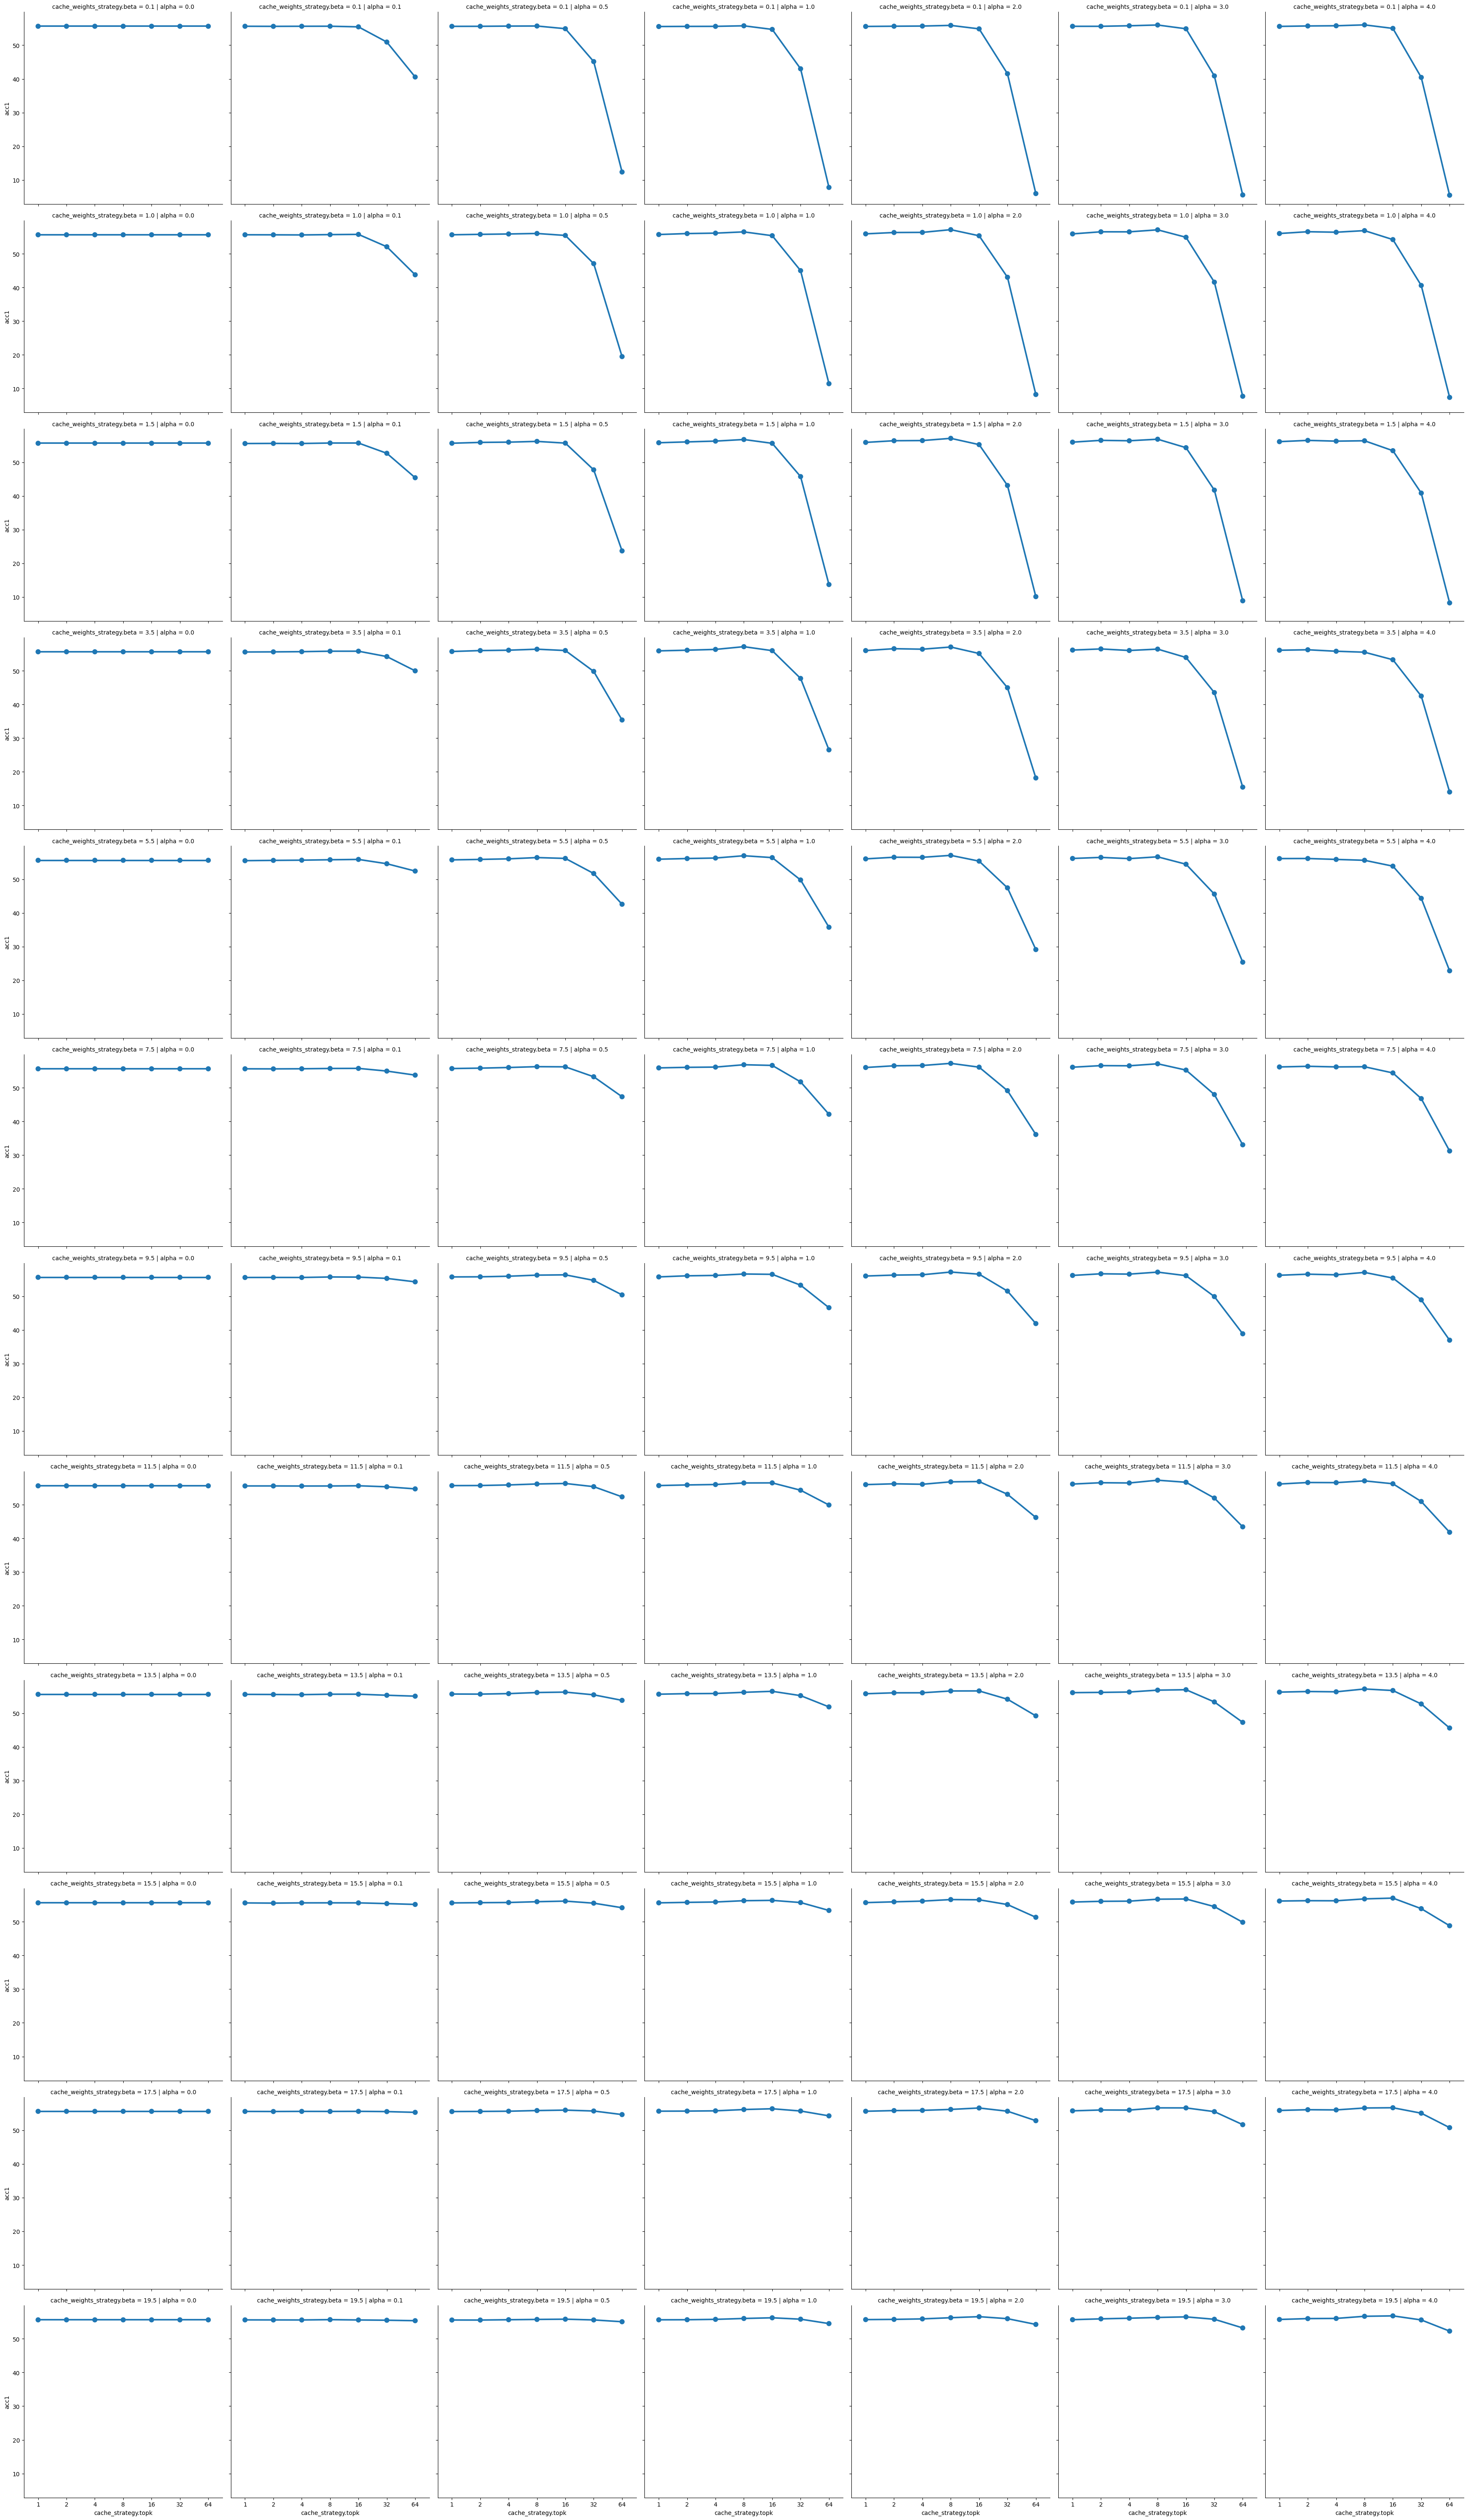

In [8]:
sns.catplot(
    data=part_df, x='cache_strategy.topk', y='acc1', col='alpha',
    row='cache_weights_strategy.beta', kind='point', #hue='cache_value_strategy.scale'
)
plt.savefig('data/clip_search_1.png')

In [11]:
log_records_df.sort_values('acc1', ascending=False).head()

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta
306,image_attention,INFO,3.0,57.293869,89.752518,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,11.5
291,image_attention,INFO,2.0,57.244124,89.541102,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,7.5
314,image_attention,INFO,4.0,57.219251,89.752518,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,13.5
298,image_attention,INFO,2.0,57.194379,89.740082,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,9.5
299,image_attention,INFO,3.0,57.169506,89.454048,summer_clip.clip_searcher.cache_strategy.TopKS...,8,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,9.5


In [12]:
log_records_df[log_records_df['alpha'] == 0].head(1)

,name,levelname,alpha,acc1,acc5,cache_strategy._target_,cache_strategy.topk,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,0.0,55.62741,89.764955,summer_clip.clip_searcher.cache_strategy.TopKS...,1,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
